In [2]:
import os
os.chdir(r'D:\machinelearning\aspr\training')
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import cv2 as cv

In [3]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNEL=3
EPOCHS=50

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "sittingposture",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1492 files belonging to 2 classes.


In [5]:
class_names=dataset.class_names
class_names

['correct_pose', 'incorrect_pose']

In [6]:
len(dataset)

47

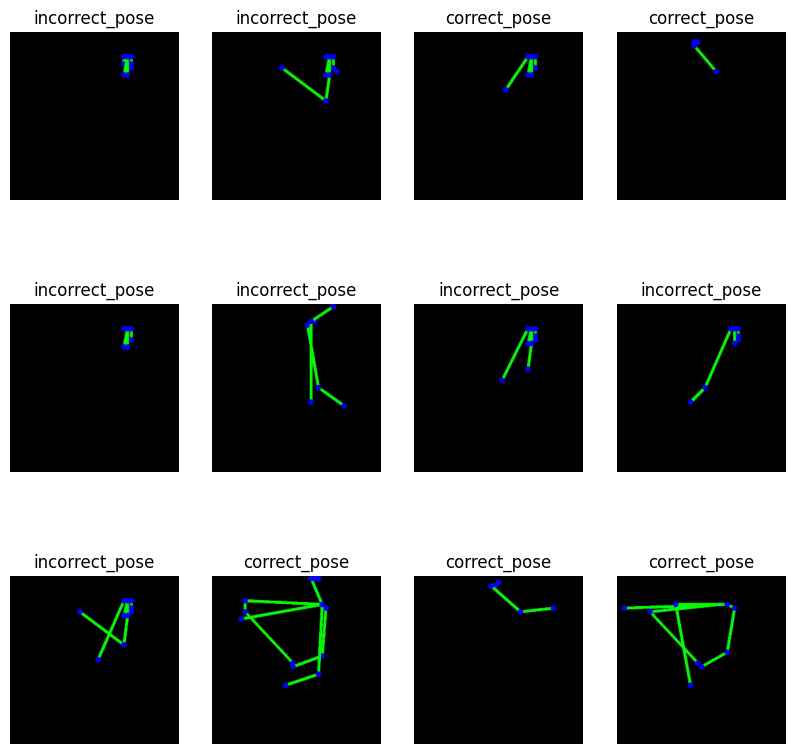

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
len(dataset) #4500/32

47

In [9]:
train_size=0.8
len(dataset)*train_size

37.6

In [10]:
train_ds=dataset.take(37)
len(train_ds)

37

In [11]:
test_ds=dataset.skip(37)
len(test_ds)

10

In [12]:
val_size=0.1
len(dataset)*val_size

4.7

In [13]:
val_ds=test_ds.take(4)
len(val_ds)

4

In [14]:
test_ds=test_ds.skip(4)
len(test_ds)

6

In [15]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)

    
    train_size=int(train_split*ds_size)

    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)

    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [16]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

37

In [18]:
len(val_ds)

4

In [19]:
len(test_ds)

6

In [20]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [22]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [23]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNEL)
n_classes=2
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [37]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [38]:
history=model.fit(
        train_ds,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=val_ds
    )

Epoch 1/50
37/37 [==============================] - 105s 3s/step - loss: 1.1191 - accuracy: 0.5887 - val_loss: 0.6345 - val_accuracy: 0.6328
Epoch 2/50
37/37 [==============================] - 79s 2s/step - loss: 0.6153 - accuracy: 0.6715 - val_loss: 0.5372 - val_accuracy: 0.7344
Epoch 3/50
37/37 [==============================] - 74s 2s/step - loss: 0.5766 - accuracy: 0.7039 - val_loss: 0.5374 - val_accuracy: 0.7266
Epoch 4/50
37/37 [==============================] - 74s 2s/step - loss: 0.5409 - accuracy: 0.7312 - val_loss: 0.4810 - val_accuracy: 0.7734
Epoch 5/50
37/37 [==============================] - 74s 2s/step - loss: 0.5018 - accuracy: 0.7628 - val_loss: 0.4440 - val_accuracy: 0.8281
Epoch 6/50
37/37 [==============================] - 73s 2s/step - loss: 0.4815 - accuracy: 0.7679 - val_loss: 0.4402 - val_accuracy: 0.8203
Epoch 7/50
37/37 [==============================] - 72s 2s/step - loss: 0.4452 - accuracy: 0.7986 - val_loss: 0.3884 - val_accuracy: 0.8203
Epoch 8/50
37/37 [=

In [25]:
scores = model.evaluate(test_ds)

NameError: name 'model' is not defined

In [40]:
scores

[0.2433384507894516, 0.9010416865348816]

In [41]:
history

In [42]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 37}

In [43]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [44]:
history.history['accuracy']

[0.5887371897697449,
 0.6715016961097717,
 0.7039248943328857,
 0.7312286496162415,
 0.7627986073493958,
 0.7679181098937988,
 0.7986348271369934,
 0.8250853419303894,
 0.8242321014404297,
 0.8208191394805908,
 0.835324227809906,
 0.8182593584060669,
 0.8378839492797852,
 0.8728668689727783,
 0.8609215021133423,
 0.8549488186836243,
 0.8566552996635437,
 0.8660409450531006,
 0.8592150211334229,
 0.8703071475028992,
 0.8899317383766174,
 0.8703071475028992,
 0.8660409450531006,
 0.8856655359268188,
 0.8771331310272217,
 0.8796928524971008,
 0.8788396120071411,
 0.8796928524971008,
 0.8976109027862549,
 0.8899317383766174,
 0.8933447003364563,
 0.8907849788665771,
 0.8848122954368591,
 0.9052901268005371,
 0.8959044218063354,
 0.8967576622962952,
 0.9078498482704163,
 0.8993173837661743,
 0.9172354936599731,
 0.9095563292503357,
 0.8967576622962952,
 0.894197940826416,
 0.9163822531700134,
 0.9129692912101746,
 0.9215016961097717,
 0.9078498482704163,
 0.9010238647460938,
 0.916382253170

In [45]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

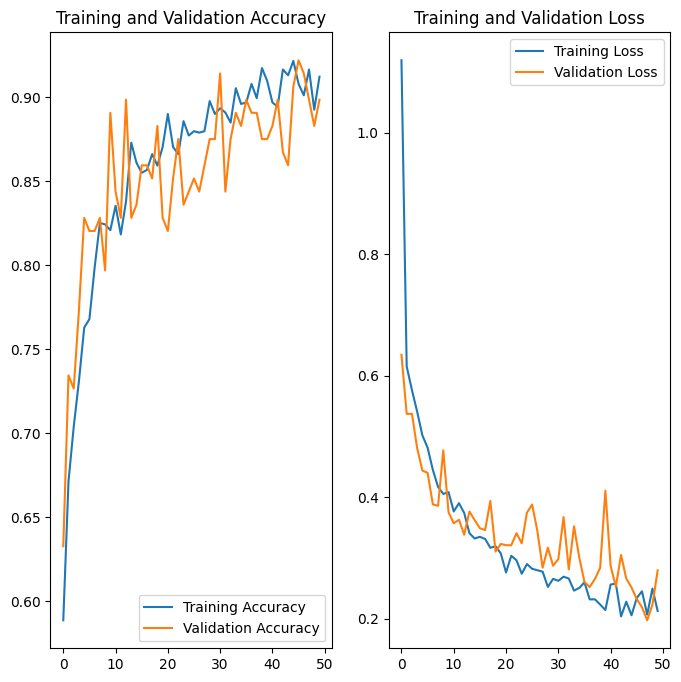

In [46]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

first image to predict
first image actual label: correct_pose


NameError: name 'model' is not defined

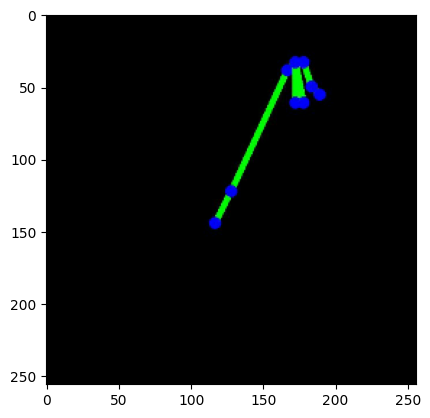

In [26]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print('first image to predict')
    plt.imshow(first_image)
    print("first image actual label:",class_names[first_label])

    batch_prediction=model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

1/1 [==============================] - 0s 45ms/step


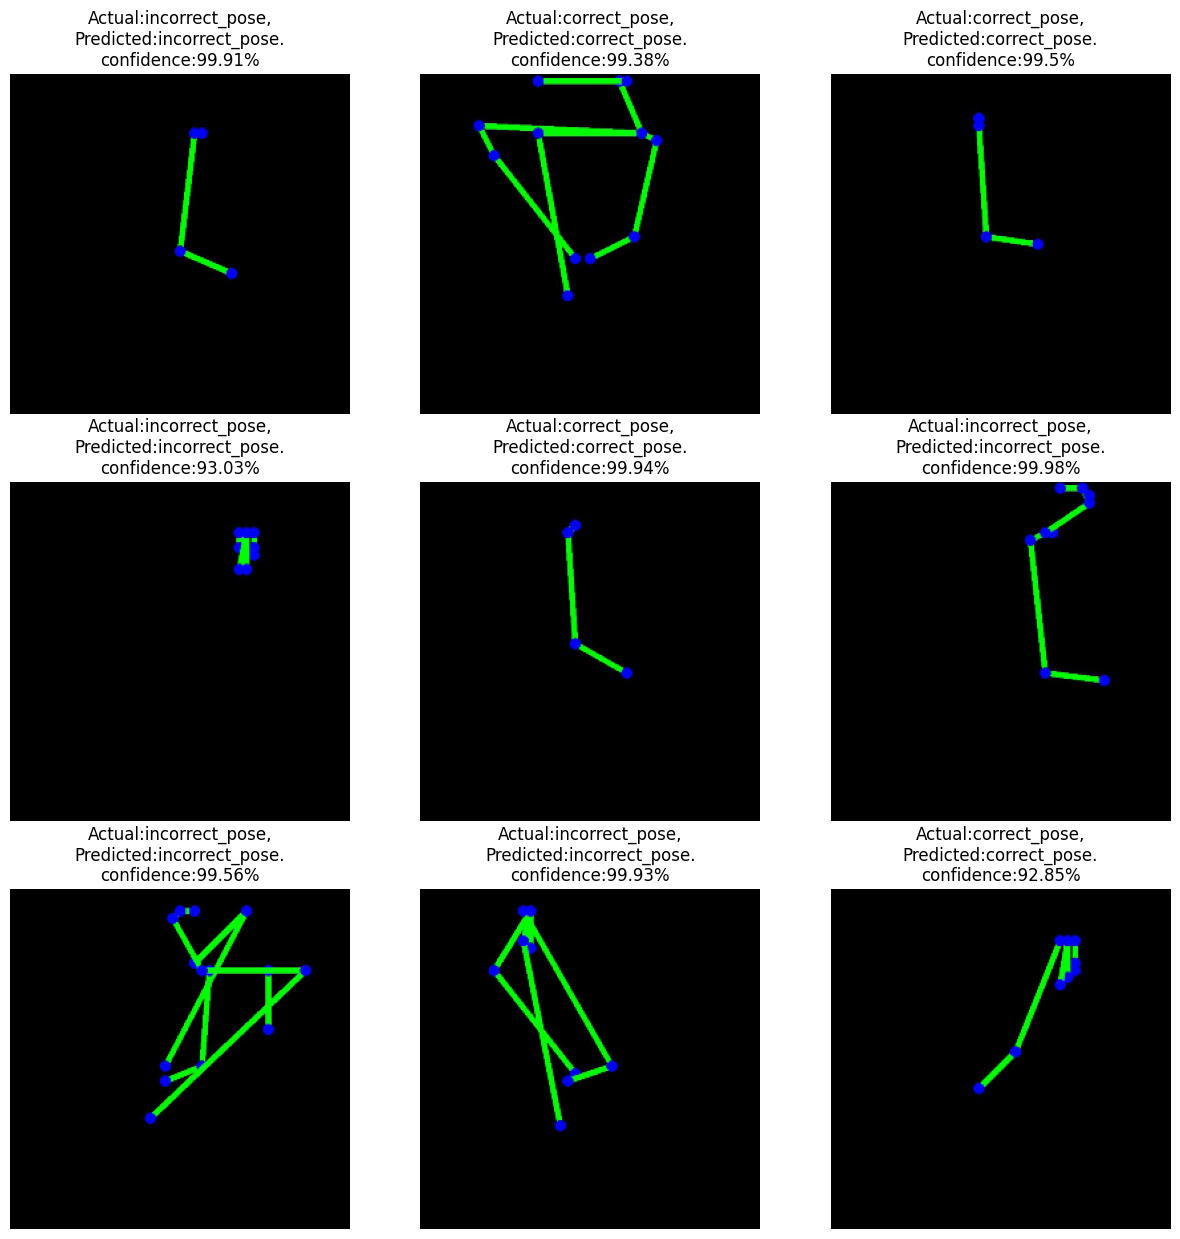

In [81]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class=class_names[labels[i]]

        plt.title(f"Actual:{actual_class},\nPredicted:{predicted_class}.\nconfidence:{confidence}%")
        plt.axis("off")

In [50]:
model_version=1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [23]:
%matplotlib inline 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [24]:
os.chdir(r'D:\machinelearning\aspr\training')
net=cv.dnn.readNetFromTensorflow(r'graph_opt.pb')
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

In [25]:
inWidth=368
inHeight=368
thr=0.2

In [26]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                   "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                   "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
                   "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
                   ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
                   ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
                   ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
                   ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

[[[199 187 185]
  [198 186 184]
  [190 178 176]
  ...
  [ 36  32  98]
  [ 38  29  96]
  [ 43  34 101]]

 [[191 178 176]
  [191 179 177]
  [188 175 173]
  ...
  [ 35  31  97]
  [ 37  30  97]
  [ 46  37 104]]

 [[178 163 160]
  [179 167 163]
  [182 167 164]
  ...
  [ 35  31  96]
  [ 38  32  97]
  [ 46  40 105]]

 ...

 [[ 58  58  52]
  [ 64  61  56]
  [ 63  59  54]
  ...
  [ 38  17  80]
  [ 44  17  81]
  [ 51  21  86]]

 [[ 55  52  48]
  [ 59  56  52]
  [ 63  58  55]
  ...
  [ 42  15  79]
  [ 51  16  83]
  [ 59  22  90]]

 [[ 51  48  44]
  [ 56  53  49]
  [ 67  60  57]
  ...
  [ 44  14  79]
  [ 52  15  83]
  [ 62  23  91]]]


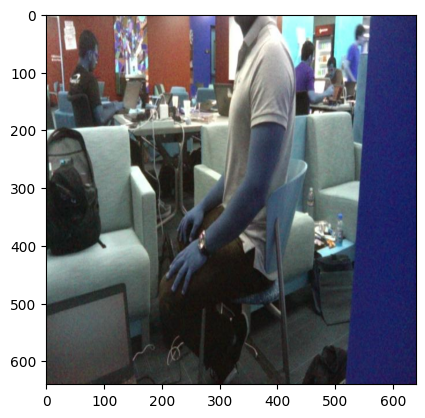

In [27]:
os.chdir('D:\machinelearning\sample_model_2\correct')
img=cv.imread("37_jpg.rf.3b62e147f6673f8e15cb29e9fdcdda2a.jpg")
print(img)
plt.imshow(img)

In [28]:
def pose_estimation(frame):
    frameWidth=frame.shape[1]
    frameHeight=frame.shape[0]
    frame1 = np.zeros_like(frame)
    net.setInput(cv.dnn.blobFromImage(frame,1.0,(inWidth,inHeight),(127.5,127.5,127.5),swapRB=True,crop=False))
    out = net.forward()
    out=out[:,:19,:,:]
    assert(len(BODY_PARTS) <= out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponding body's part.
        heatMap = out[0, i, :, :]
        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]

        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame1, points[idFrom], points[idTo], (0, 255, 0), 10)
            cv.ellipse(frame1, points[idFrom], (10, 10), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame1, points[idTo], (10, 10), 0, 0, 360, (0, 0, 255), cv.FILLED)
    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame1, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    return frame1

In [29]:
model = tf.keras.models.load_model(r'D:\machinelearning\aspr\models\1')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                 

In [30]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(img)
    img_array=tf.expand_dims(img,0)

    predictions=model.predict(img_array)

    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

[[[199 187 185]
  [198 186 184]
  [190 178 176]
  ...
  [ 36  32  98]
  [ 38  29  96]
  [ 43  34 101]]

 [[191 178 176]
  [191 179 177]
  [188 175 173]
  ...
  [ 35  31  97]
  [ 37  30  97]
  [ 46  37 104]]

 [[178 163 160]
  [179 167 163]
  [182 167 164]
  ...
  [ 35  31  96]
  [ 38  32  97]
  [ 46  40 105]]

 ...

 [[ 58  58  52]
  [ 64  61  56]
  [ 63  59  54]
  ...
  [ 38  17  80]
  [ 44  17  81]
  [ 51  21  86]]

 [[ 55  52  48]
  [ 59  56  52]
  [ 63  58  55]
  ...
  [ 42  15  79]
  [ 51  16  83]
  [ 59  22  90]]

 [[ 51  48  44]
  [ 56  53  49]
  [ 67  60  57]
  ...
  [ 44  14  79]
  [ 52  15  83]
  [ 62  23  91]]]
1/1 [==============================] - 0s 277ms/step
('correct_pose', 99.02)


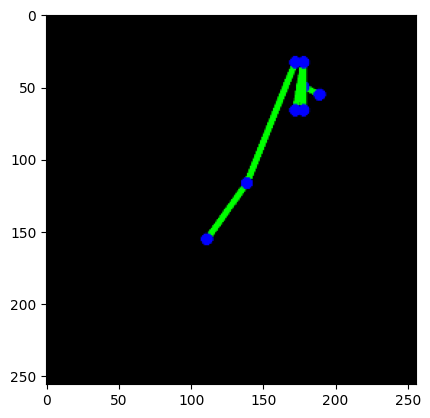

In [31]:
os.chdir('D:\machinelearning\sample_model_2\correct')
img=cv.imread("37_jpg.rf.3b62e147f6673f8e15cb29e9fdcdda2a.jpg")
print(img)
plt.imshow(img)
estimated_img=pose_estimation(img)
resized_image = cv.resize(estimated_img, (256, 256))
img1=Image.fromarray(resized_image)
x=predict(model,img1)
print(x)
plt.imshow(img1)

In [33]:
import numpy as np
import cv2 as cv
from PIL import Image

cap = cv.VideoCapture(0)

if not cap.isOpened():
    print("Cannot open camera")
    exit()

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    # Our operations on the frame come here
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # Display the resulting frame
    cv.imshow('frame', gray)

    estimated_img = pose_estimation(frame)
    resized_image = cv.resize(estimated_img, (256, 256))
    img1 = Image.fromarray(resized_image)
    x = predict(model, img1)
    print(x)
    
    # Display predicted class
    font = cv.FONT_HERSHEY_SIMPLEX
    cv.putText(frame, x[0], (x1, y1 - 10), font, 0.9, (0, 255, 0), 2, cv.LINE_AA)

    # Show the frame with bounding box and predicted class
    cv.imshow('Frame with Bounding Box', frame)

    if cv.waitKey(1) == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv.destroyAllWindows()


1/1 [==============================] - 0s 50ms/step
('correct_pose', 98.33)
1/1 [==============================] - 0s 49ms/step
('incorrect_pose', 93.94)
1/1 [==============================] - 0s 47ms/step
('incorrect_pose', 98.58)
1/1 [==============================] - 0s 39ms/step
('incorrect_pose', 86.1)
1/1 [==============================] - 0s 63ms/step
('correct_pose', 57.33)
1/1 [==============================] - 0s 31ms/step
('correct_pose', 57.33)
1/1 [==============================] - 0s 67ms/step
('incorrect_pose', 72.9)
1/1 [==============================] - 0s 47ms/step
('correct_pose', 57.33)
1/1 [==============================] - 0s 54ms/step
('correct_pose', 57.33)
1/1 [==============================] - 0s 46ms/step
('incorrect_pose', 70.04)
1/1 [==============================] - 0s 41ms/step
('incorrect_pose', 89.58)
1/1 [==============================] - 0s 36ms/step
('incorrect_pose', 99.12)
1/1 [==============================] - 0s 35ms/step
('incorrect_pose', 99.12

In [45]:
print(cv.__version__)

4.8.0
